## **Step 0 — Setup & Imports**

We begin by importing essential libraries for our project:  
- **General utilities**: file handling, randomness, math, timing.  
- **Image processing**: OpenCV, NumPy, and PIL for working with images.  
- **PyTorch**: core modules for building and training deep learning models.  
- **Data utilities**: Dataset, DataLoader, and random splitting.  
- **TorchVision models**: pre-trained architectures for transfer learning.  


In [ ]:
# =========================
# Step 0 — Setup & Imports
# =========================
import os, random, math, time
from glob import glob

import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models




## **📌 Step 1 — Config & Reproducibility**  

- ⏳ **Progress bar**: Uses `tqdm` for loop tracking (with a safe fallback).  
- 🎲 **Reproducibility**: `seed_everything()` fixes random seeds for Python, NumPy, and PyTorch to ensure consistent results.  
- 📂 **Configuration**: The `CFG` class stores key settings:  
  - Paths to images & masks  
  - Image size (256×256)  
  - Batch size, epochs, learning rate, weight decay  
  - Device setup (CPU/GPU)  
  - Train/validation/test splits  
  - Save path for the trained model  

👉 Centralizing these parameters makes experiments easy to adjust and reproducible.  


In [ ]:
# Optional: tqdm progress bar
try:
    from tqdm.auto import tqdm
except:
    def tqdm(x, **k): return x

# ---- Reproducibility
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

# ---- Config
class CFG:
    DATA_ROOT = "/content/drive/MyDrive/Kwsir_Seg_Research"    # has "images" and "masks" folders
    IMG_DIR   = "images"
    MSK_DIR   = "masks"
    IMG_SIZE  = 256
    BATCH_SIZE= 4
    EPOCHS    = 100
    LR        = 1e-3
    WD        = 1e-4
    DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"
    NUM_WORKERS = 2
    VAL_SPLIT = 0.15
    TEST_SPLIT= 0.15
    PRETRAINED_RESNET = True            # encoder init
    SAVE_PATH = "transunet_kvasir.pth"
cfg = CFG()

## **🖼️ Step 2 — Listing Images & Masks**  

- 🔍 **Function**: `list_images_masks()` scans the dataset folders and pairs each image with its corresponding mask.  
- 📂 **Paths**: Uses `glob` to gather image files, then matches them with mask files by filename.  
- ✅ **Validation**: Prints a few example paths and checks that pairs actually exist.  
- ⚠️ **Error handling**: Raises an error if no valid pairs are found, helping catch dataset path issues early.  

👉 This ensures we load images and masks in proper **aligned pairs**, which is essential for segmentation tasks.  


In [ ]:
def list_images_masks(root, img_dir="images", msk_dir="masks"):
    img_paths = sorted(glob(os.path.join(root, img_dir, "*")))
    msk_paths = [os.path.join(root, msk_dir, os.path.basename(p)) for p in img_paths]

    print("Example image path:", img_paths[:3])
    print("Example mask path:", msk_paths[:3])

    pairs = [(i,m) for i,m in zip(img_paths, msk_paths) if os.path.exists(m)]
    print("Total pairs found:", len(pairs))

    if len(pairs) == 0:
        raise ValueError("No image–mask pairs found. Check DATA_ROOT and folder names (images/, masks/).")
    imgs, msks = zip(*pairs)
    return list(imgs), list(msks)


## **🛠️ Step 3 — Dataset Preparation (Kvasir-SEG)**  

- 🖼️ **Dataset**: Uses the **Kvasir-SEG** dataset (RGB endoscopy images + binary masks).  
- 🔄 **Preprocessing**:  
  - Resize images/masks to 256×256 while preserving aspect ratio with padding.  
  - Normalize pixel values to `[0,1]`, with optional z-normalization per image.  
  - Convert masks into binary format.  
- 🎨 **Augmentations**: Random flips, small rotations, brightness/contrast changes, and Gaussian blur (applied consistently to image & mask).  
- 📦 **Custom Dataset**: `KvasirSegDataset` handles reading, preprocessing, augmentations, and tensor conversion.  
- ✂️ **Splitting**: The dataset is randomly divided into **train, validation, and test** sets based on predefined ratios.  
- 🚚 **Data Loaders**: Efficient batching, shuffling, and loading with PyTorch `DataLoader`.  

👉 Final output shows the count of samples in each split (Train/Val/Test).  


In [ ]:
# ======================================
# Step 1 — Dataset Preparation (Kvasir)
# ======================================
# Dataset: Kvasir-SEG (RGB images + binary masks), varying resolution.
# Preprocessing: resize to 256x256, per-image normalization, augmentations.

def list_images_masks(root, img_dir="images", msk_dir="masks"):
    img_paths = sorted(glob(os.path.join(root, img_dir, "*")))
    msk_paths = [os.path.join(root, msk_dir, os.path.basename(p)) for p in img_paths]
    # keep only pairs that exist
    pairs = [(i,m) for i,m in zip(img_paths, msk_paths) if os.path.exists(m)]
    imgs, msks = zip(*pairs)
    return list(imgs), list(msks)

def read_image(path):
    # BGR -> RGB
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def read_mask(path):
    msk = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # binarize just in case
    msk = (msk > 127).astype(np.uint8) * 255
    return msk

def resize_keep_ar_pad(img, size):
    h, w = img.shape[:2]
    scale = size / max(h, w)
    nh, nw = int(h * scale), int(w * scale)
    img_res = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_LINEAR)
    pad_h, pad_w = size - nh, size - nw
    top = pad_h // 2; bottom = pad_h - top
    left = pad_w // 2; right = pad_w - left
    if img.ndim == 3:
        img_pad = cv2.copyMakeBorder(img_res, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0,0,0))
    else:
        img_pad = cv2.copyMakeBorder(img_res, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return img_pad

def random_augment(img, msk):
    # Light, deterministic per pair (apply same to img & mask)
    # flips
    if random.random() < 0.5:
        img = cv2.flip(img, 1); msk = cv2.flip(msk, 1)
    # rotations
    if random.random() < 0.3:
        angle = random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D((cfg.IMG_SIZE/2, cfg.IMG_SIZE/2), angle, 1.0)
        img = cv2.warpAffine(img, M, (cfg.IMG_SIZE, cfg.IMG_SIZE), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        msk = cv2.warpAffine(msk, M, (cfg.IMG_SIZE, cfg.IMG_SIZE), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
    # color jitter (brightness/contrast)
    if random.random() < 0.3:
        alpha = 1.0 + random.uniform(-0.15, 0.15) # contrast
        beta  = random.uniform(-15, 15)           # brightness
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    # gaussian blur
    if random.random() < 0.2:
        k = random.choice([3,5])
        img = cv2.GaussianBlur(img, (k,k), 0)
    return img, msk

class KvasirSegDataset(Dataset):
    def __init__(self, img_paths, msk_paths, train=True):
        self.imgs = img_paths; self.msks = msk_paths; self.train = train

    def __len__(self): return len(self.imgs)

    def __getitem__(self, idx):
        img = read_image(self.imgs[idx])
        msk = read_mask(self.msks[idx])
        # resize with padding to preserve AR
        img = resize_keep_ar_pad(img, cfg.IMG_SIZE)
        msk = resize_keep_ar_pad(msk, cfg.IMG_SIZE)
        if self.train:
            img, msk = random_augment(img, msk)
        # to float tensors, normalize [0,1]
        img = img.astype(np.float32) / 255.0
        # per-image z-norm (optional)
        img = (img - img.mean(axis=(0,1), keepdims=True)) / (img.std(axis=(0,1), keepdims=True) + 1e-6)
        msk = (msk > 127).astype(np.float32)
        # HWC->CHW
        img = torch.from_numpy(np.transpose(img, (0,2,1))[0]) if False else torch.from_numpy(np.transpose(img, (2,0,1)))
        msk = torch.from_numpy(msk[None, ...])  # 1xHxW
        return img, msk

# ---- Build splits and loaders
all_imgs, all_msks = list_images_masks(cfg.DATA_ROOT, cfg.IMG_DIR, cfg.MSK_DIR)
N = len(all_imgs)
n_test = int(N * cfg.TEST_SPLIT)
n_val  = int(N * cfg.VAL_SPLIT)
n_train= N - n_test - n_val

indices = list(range(N))
random.shuffle(indices)
train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train+n_val]
test_idx  = indices[n_train+n_val:]

train_ds = KvasirSegDataset([all_imgs[i] for i in train_idx], [all_msks[i] for i in train_idx], train=True)
val_ds   = KvasirSegDataset([all_imgs[i] for i in val_idx],   [all_msks[i] for i in val_idx],   train=False)
test_ds  = KvasirSegDataset([all_imgs[i] for i in test_idx],  [all_msks[i] for i in test_idx],  train=False)

train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True,  num_workers=cfg.NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=cfg.NUM_WORKERS, pin_memory=True)



test_loader  = DataLoader(test_ds,  batch_size=1,              shuffle=False, num_workers=cfg.NUM_WORKERS, pin_memory=True)

print(f"Train/Val/Test: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")


Train/Val/Test: 700/150/150


## **🎨 Step 4 — Visualizing Dataset Samples**  

- 🖼️ **Function**: `visualize_dataset_samples()` displays random image–mask pairs from the dataset.  
- 🔍 **Views**: For each sample, it shows:  
  1. The original RGB image  
  2. The binary segmentation mask  
  3. An overlay (image + red mask) for clarity  
- 📏 **Consistency**: Images and masks are resized to a fixed size (256×256) for uniform display.  
- ✨ **Purpose**: Helps verify correct alignment of images and masks before training.  

👉 Running this function gives a quick sanity check of the dataset’s quality and preprocessing.  


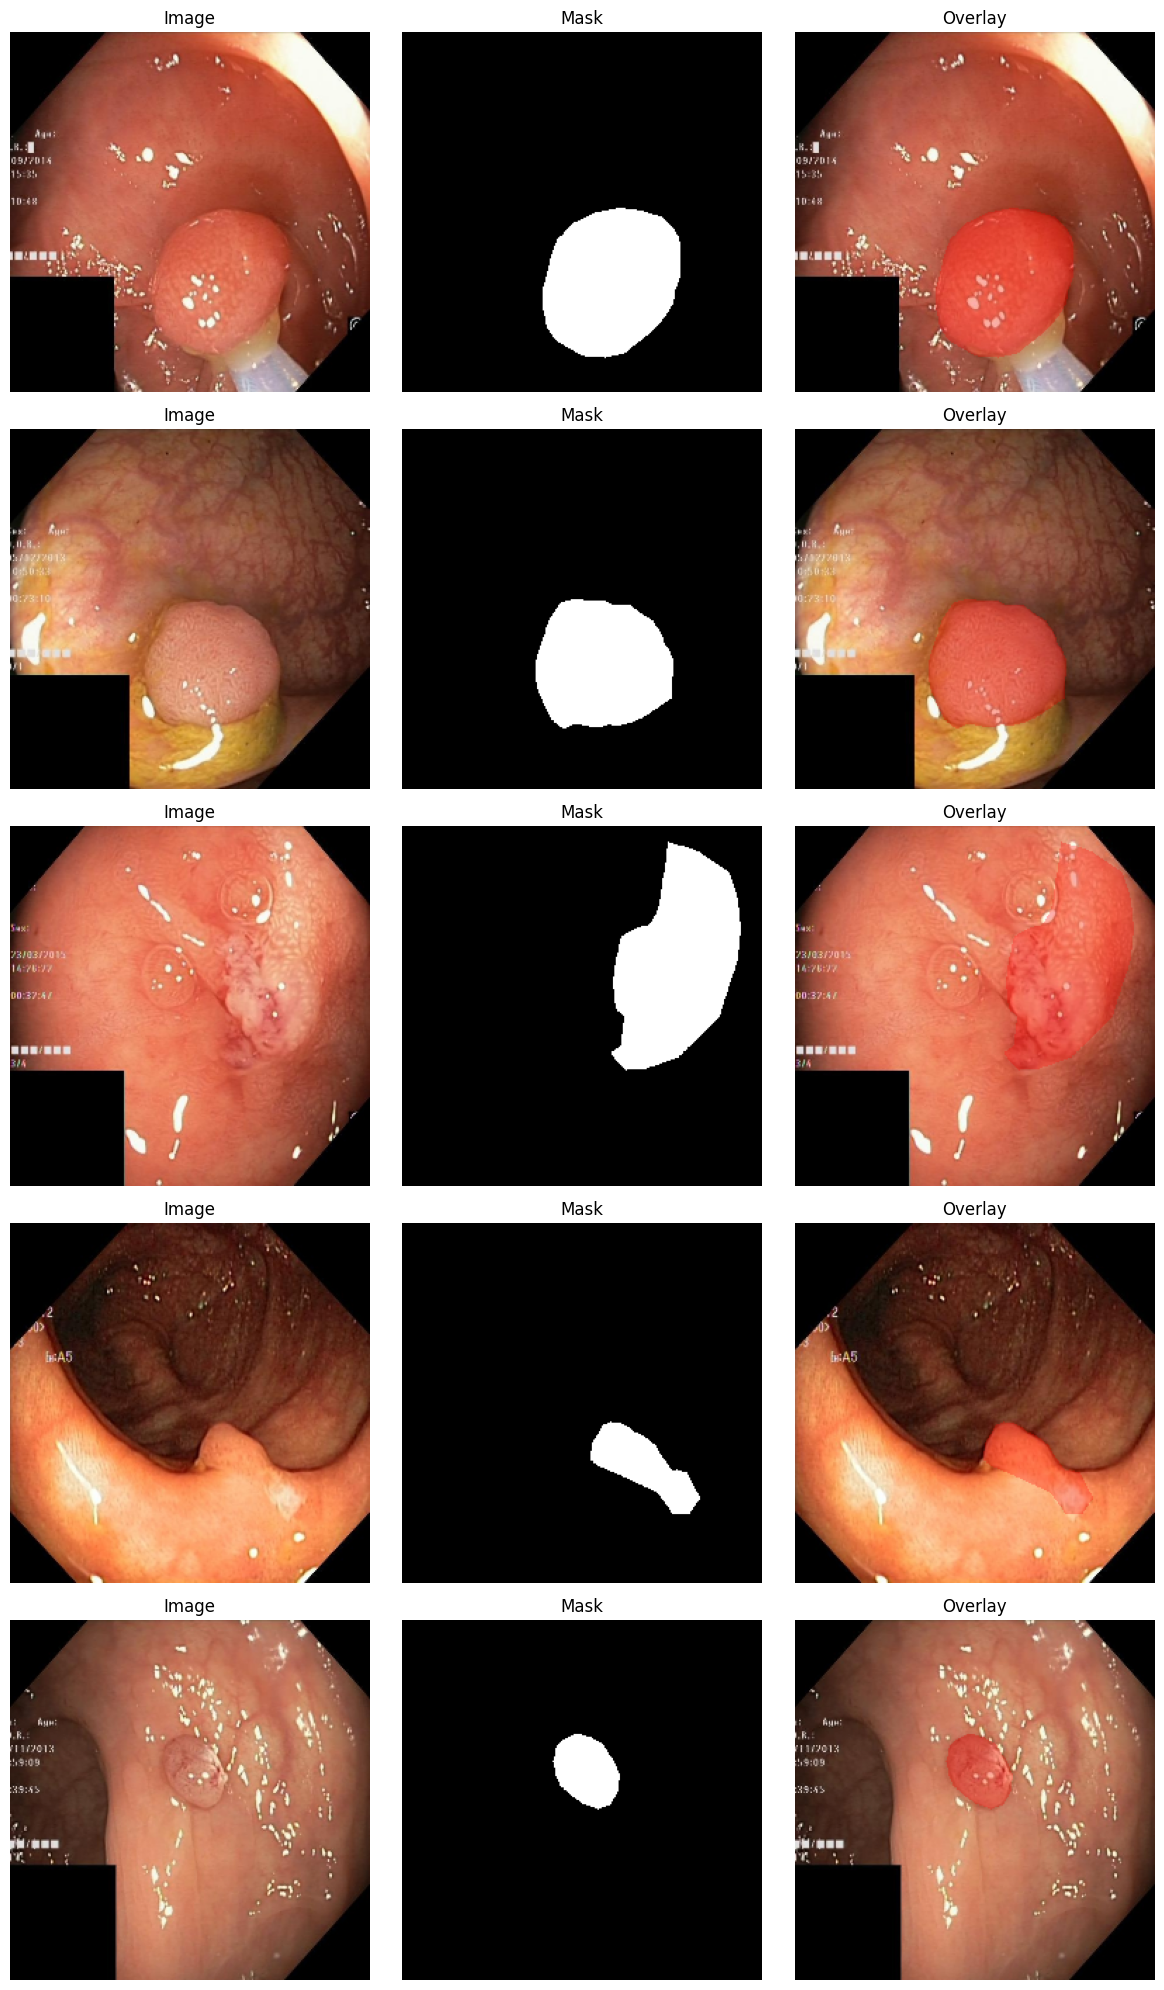

In [ ]:
import matplotlib.pyplot as plt

def visualize_dataset_samples(img_paths, msk_paths, n=5, img_size=256):
    """
    Display images with their masks and overlay.
    img_paths: list of image file paths
    msk_paths: list of mask file paths (aligned by index with img_paths)
    n: number of samples to display
    """
    indices = random.sample(range(len(img_paths)), n)

    plt.figure(figsize=(12, n*4))

    for i, idx in enumerate(indices):
        # Load image and mask
        img = cv2.imread(img_paths[idx], cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(msk_paths[idx], cv2.IMREAD_GRAYSCALE)

        # Resize for consistent display
        img = cv2.resize(img, (img_size, img_size))
        mask = cv2.resize(mask, (img_size, img_size))
        mask_bin = (mask > 127).astype(np.uint8) * 255

        # Overlay: add red mask with alpha blending
        overlay = img.copy()
        overlay[mask_bin==255] = (255, 0, 0)  # red overlay
        blended = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)

        # Plot original, mask, overlay
        plt.subplot(n, 3, i*3+1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(n, 3, i*3+2)
        plt.imshow(mask_bin, cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.subplot(n, 3, i*3+3)
        plt.imshow(blended)
        plt.title("Overlay")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_dataset_samples(all_imgs, all_msks, n=5, img_size=256)


## **📊 Step 5 — Metrics & Loss Functions**  

- 🧮 **Dice Coefficient**: Measures overlap between predicted masks and ground truth. Higher values mean better segmentation.  
- 🔲 **IoU (Intersection over Union)**: Another common metric for evaluating segmentation quality.  
- ⚖️ **Dice + BCE Loss**:  
  - Combines **Binary Cross-Entropy (BCE)** for pixel-wise accuracy with **Dice loss** for region overlap.  
  - The balance is controlled with a weight (`bce_weight`).  
  - Helps stabilize training and improves segmentation of small regions.  

👉 These metrics and loss functions guide the model toward producing **accurate and well-overlapped masks**.  


In [ ]:
# =======================================
# Metrics & Loss (Dice + BCE)
# =======================================
def dice_coef(pred, target, eps=1e-6):
    # pred: logits or probs? -> expect probabilities here
    pred_flat = pred.reshape(pred.size(0), -1)
    tgt_flat  = target.reshape(target.size(0), -1)
    inter = (pred_flat * tgt_flat).sum(dim=1)
    denom = pred_flat.sum(dim=1) + tgt_flat.sum(dim=1)
    dice = (2. * inter + eps) / (denom + eps)
    return dice.mean()

def iou_coef(pred, target, eps=1e-6):
    pred_flat = pred.reshape(pred.size(0), -1)
    tgt_flat  = target.reshape(target.size(0), -1)
    inter = (pred_flat * tgt_flat).sum(dim=1)
    union = pred_flat.sum(dim=1) + tgt_flat.sum(dim=1) - inter
    iou = (inter + eps) / (union + eps)
    return iou.mean()

class DiceBCELoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.bce_w = bce_weight
    def forward(self, logits, target):
        bce = self.bce(logits, target)
        probs = torch.sigmoid(logits)
        dice = 1. - dice_coef(probs, target)
        return self.bce_w * bce + (1 - self.bce_w) * dice


## **🧩 Step 6 — TransUNet Model (ResNet + Transformer)**  

- 🏗️ **Architecture**: A hybrid model that combines a CNN encoder with a Transformer bottleneck and a U-Net style decoder.  
- 🔹 **Components**:  
  - **ConvBlock**: Two convolutional layers with BatchNorm + ReLU.  
  - **UpBlock**: Upsampling + skip connections for decoder reconstruction.  
  - **BottleneckTransformer**: Flattens feature maps into tokens, adds positional embeddings, and processes them with a Transformer encoder.  
  - **TransUNet**:  
    - **Encoder**: ResNet backbone (`resnet34` or `resnet50`) for multi-scale feature extraction.  
    - **Transformer bottleneck**: Enhances global context understanding.  
    - **Decoder**: U-Net style upsampling with skip connections for precise segmentation.  
    - **Output**: Final convolutional layer predicts segmentation masks.  

👉 This design leverages **CNNs for local features** and **Transformers for global context**, making it powerful for medical image segmentation.  


In [ ]:
# ==================================================
# TransUNet Model (ResNet + Transformer)
# ==================================================
# Encoder: ResNet (torchvision) for multiscale feats
# Bottleneck: Transformer encoder over flattened tokens
# Decoder: U-Net upsampling with skip connections

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.conv(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv = ConvBlock(in_ch + skip_ch, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        # pad if needed due to odd dims
        dh = skip.size(2) - x.size(2)
        dw = skip.size(3) - x.size(3)
        if dh != 0 or dw != 0:
            x = F.pad(x, [dw//2, dw - dw//2, dh//2, dh - dh//2])
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class BottleneckTransformer(nn.Module):
    def __init__(self, c, nhead=8, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=c, nhead=nhead, dim_feedforward=4*c, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pos_embed = None  # learnable PE; init lazily
        self.c = c
    def forward(self, x):
        B, C, H, W = x.shape
        if self.pos_embed is None or self.pos_embed.shape[1] != H*W:
            self.pos_embed = nn.Parameter(torch.zeros(1, H*W, self.c, device=x.device))
            nn.init.trunc_normal_(self.pos_embed, std=0.02)
        tokens = x.flatten(2).transpose(1,2)        # B x (HW) x C
        tokens = tokens + self.pos_embed
        tokens = self.transformer(tokens)           # B x (HW) x C
        x_out = tokens.transpose(1,2).reshape(B, C, H, W)
        return x_out

class TransUNet(nn.Module):
    def __init__(self, num_classes=1, backbone="resnet34", pretrained=True):
        super().__init__()
        assert backbone in ["resnet34", "resnet50"]
        if backbone == "resnet34":
            enc = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1 if pretrained else None)
            chs = [64, 64, 128, 256, 512]
        else:
            enc = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
            chs = [64, 256, 512, 1024, 2048]
        # Stem + stages
        self.stem = nn.Sequential(enc.conv1, enc.bn1, enc.relu)
        self.pool = enc.maxpool
        self.layer1 = enc.layer1
        self.layer2 = enc.layer2
        self.layer3 = enc.layer3
        self.layer4 = enc.layer4  # bottleneck feat

        # Project bottleneck to manageable C for transformer (e.g., 512)
        bottleneck_c = 512 if backbone == "resnet34" else 512
        self.bottleneck_proj = nn.Conv2d(chs[-1], bottleneck_c, 1)
        self.transformer = BottleneckTransformer(c=bottleneck_c, nhead=8, num_layers=2)

        # Decoder
        self.up4 = UpBlock(bottleneck_c, chs[-2], 256)    # with skip from layer3
        self.up3 = UpBlock(256,           chs[-3], 128)   # skip layer2
        self.up2 = UpBlock(128,           chs[-4], 64)    # skip layer1
        self.up1 = UpBlock(64,            chs[0],  32)    # skip stem

        self.out_conv = nn.Conv2d(32, num_classes, 1)

    def forward(self, x):
        # encoder
        x0 = self.stem(x)            # (B, chs[0], H/2, W/2)
        x1 = self.pool(x0)           # (B, chs[0], H/4, W/4)
        x1 = self.layer1(x1)         # (B, chs[1], H/4, W/4)
        x2 = self.layer2(x1)         # (B, chs[2], H/8, W/8)
        x3 = self.layer3(x2)         # (B, chs[3], H/16,W/16)
        x4 = self.layer4(x3)         # (B, chs[4], H/32,W/32)

        # bottleneck transformer
        x4 = self.bottleneck_proj(x4)   # -> (B, 512, H/32, W/32)
        x4 = self.transformer(x4)

        # decoder with skips
        d4 = self.up4(x4, x3)
        d3 = self.up3(d4, x2)
        d2 = self.up2(d3, x1)
        d1 = self.up1(d2, x0)

        logits = self.out_conv(d1)
        # upsample to input size if needed
        if logits.size(2) != x.size(2) or logits.size(3) != x.size(3):
            logits = F.interpolate(logits, size=x.shape[-2:], mode="bilinear", align_corners=False)
        return logits


## **📊 Step 7: Training & Validation — Evaluation (Full Logging)**

- 🧮 **Loss Calculation**: Computes validation loss using the same `DiceBCELoss` as in training.  
- 🎯 **Metrics**: Records **Dice** and **IoU** scores for segmentation quality.  
- 🔍 **Detailed Tracking**: Returns the **average loss, Dice, and IoU** across the validation dataset.  
- ⚡ **No Gradient Updates**: Runs inside `torch.no_grad()` to save memory and speed up evaluation.  


In [ ]:
# ============================================
# Training & Validation (full logging)
# ============================================
def evaluate(model, loader, device, criterion):
    model.eval()
    dices, ious, losses = [], [], []
    with torch.no_grad():
        for imgs, msks in loader:
            imgs = imgs.to(device, non_blocking=True)
            msks = msks.to(device, non_blocking=True)
            logits = model(imgs)
            probs = torch.sigmoid(logits)

            # compute loss for val
            loss = criterion(logits, msks)
            losses.append(loss.item())

            dices.append(dice_coef(probs, msks).item())
            ious.append(iou_coef(probs, msks).item())
    return np.mean(losses), np.mean(dices), np.mean(ious)


## **🔢 Step 8 — 🏋️ Training & Validation (Full Pipeline)**

Here we put everything together to train and validate our **TransUNet** model.  
This step handles optimization, monitoring, and saving the best model.  

### 🔎 What happens here:
1️⃣ **Setup**  
   - Load TransUNet model with pretrained ResNet backbone  
   - Define Dice+BCE loss, AdamW optimizer, cosine scheduler, and AMP scaler  

2️⃣ **History Tracking**  
   - Keep record of Train vs Validation Loss, Dice, and IoU across epochs  

3️⃣ **Training Loop**  
   - Forward pass with mixed precision (for speed & stability)  
   - Compute loss and backpropagate  
   - Update weights with AdamW  
   - Track per-batch Dice & IoU metrics  

4️⃣ **Validation**  
   - Evaluate model on validation set after each epoch  
   - Compute average loss, Dice, and IoU  

5️⃣ **Logging**  
   - Print side-by-side metrics for Train and Validation  
   - Append results to history for visualization later  

6️⃣ **Checkpointing**  
   - Save best model based on highest validation Dice score  

7️⃣ **Early Stopping**  
   - Stop training if no improvement for several epochs (patience)  

🎯 **Final Output**: Best model checkpoint path + full training history (loss, Dice, IoU)  


In [ ]:
def train_model():
    device = cfg.DEVICE
    model = TransUNet(num_classes=1, backbone="resnet34", pretrained=cfg.PRETRAINED_RESNET).to(device)
    criterion = DiceBCELoss(bce_weight=0.5)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LR, weight_decay=cfg.WD)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS)
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    best_val_dice = -1.0
    patience, patience_ctr = 12, 0

    history = {
        "train_loss": [], "val_loss": [],
        "train_dice": [], "val_dice": [],
        "train_iou":  [], "val_iou":  []
    }

    for epoch in range(1, cfg.EPOCHS+1):
        model.train()
        epoch_loss = 0.0
        epoch_dice, epoch_iou = 0.0, 0.0
        n_batches = len(train_loader)

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{cfg.EPOCHS}")
        for imgs, msks in pbar:
            imgs = imgs.to(device, non_blocking=True)
            msks = msks.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                logits = model(imgs)
                loss = criterion(logits, msks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # accumulate metrics
            epoch_loss += loss.item()
            probs = torch.sigmoid(logits)
            epoch_dice += dice_coef(probs, msks).item()
            epoch_iou  += iou_coef(probs, msks).item()

            pbar.set_postfix(loss=f"{loss.item():.4f}")

        scheduler.step()

        # average metrics
        train_loss = epoch_loss / n_batches
        train_dice = epoch_dice / n_batches
        train_iou  = epoch_iou / n_batches

        # ---- Validation ----
        val_loss, val_dice, val_iou = evaluate(model, val_loader, device, criterion)

        # ---- Logging ----
        print(f"Epoch {epoch}/{cfg.EPOCHS} | "
              f"Train Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f} || "
              f"Val Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

        # Save history
        history["train_loss"].append(train_loss); history["val_loss"].append(val_loss)
        history["train_dice"].append(train_dice); history["val_dice"].append(val_dice)
        history["train_iou"].append(train_iou);   history["val_iou"].append(val_iou)

        # ---- Early stopping ----
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            patience_ctr = 0
            torch.save({"model": model.state_dict(), "dice": best_val_dice}, cfg.SAVE_PATH)
            print(f"  -> Saved best model to {cfg.SAVE_PATH}")
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print("Early stopping.")
                break

    print(f"Best Val Dice: {best_val_dice:.4f}")
    return cfg.SAVE_PATH, history




## **🔢 Step 9 — 🚀 Run Training**

Now that our training function is ready, let’s **kick off the training process**.  
This will:  
- Start the training & validation loop  
- Save the best model checkpoint  
- Return the checkpoint path and full training history (loss, Dice, IoU) for later visualization  


In [ ]:
# Run training
best_ckpt_path, history = train_model()

/tmp/ipython-input-765618781.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


Epoch 1/100:   0%|          | 0/175 [00:00<?, ?it/s]

/tmp/ipython-input-765618781.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 1/100 | Train Loss: 0.4445, Dice: 0.4159, IoU: 0.2814 || Val Loss: 0.3505, Dice: 0.5461, IoU: 0.3961
  -> Saved best model to transunet_kvasir.pth


Epoch 2/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 2/100 | Train Loss: 0.3195, Dice: 0.5841, IoU: 0.4410 || Val Loss: 0.3194, Dice: 0.5992, IoU: 0.4605
  -> Saved best model to transunet_kvasir.pth


Epoch 3/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 3/100 | Train Loss: 0.2806, Dice: 0.6457, IoU: 0.5119 || Val Loss: 0.2391, Dice: 0.6924, IoU: 0.5563
  -> Saved best model to transunet_kvasir.pth


Epoch 4/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 4/100 | Train Loss: 0.3137, Dice: 0.6037, IoU: 0.4693 || Val Loss: 0.2783, Dice: 0.6725, IoU: 0.5424


Epoch 5/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 5/100 | Train Loss: 0.2548, Dice: 0.6864, IoU: 0.5591 || Val Loss: 0.2277, Dice: 0.7268, IoU: 0.6000
  -> Saved best model to transunet_kvasir.pth


Epoch 6/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 6/100 | Train Loss: 0.2360, Dice: 0.7109, IoU: 0.5886 || Val Loss: 0.2078, Dice: 0.7591, IoU: 0.6405
  -> Saved best model to transunet_kvasir.pth


Epoch 7/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 7/100 | Train Loss: 0.2137, Dice: 0.7414, IoU: 0.6270 || Val Loss: 0.2208, Dice: 0.7537, IoU: 0.6345


Epoch 8/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 8/100 | Train Loss: 0.2581, Dice: 0.6821, IoU: 0.5589 || Val Loss: 0.2151, Dice: 0.7698, IoU: 0.6585
  -> Saved best model to transunet_kvasir.pth


Epoch 9/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 9/100 | Train Loss: 0.2154, Dice: 0.7400, IoU: 0.6261 || Val Loss: 0.2309, Dice: 0.7538, IoU: 0.6484


Epoch 10/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 10/100 | Train Loss: 0.1997, Dice: 0.7580, IoU: 0.6470 || Val Loss: 0.1959, Dice: 0.7721, IoU: 0.6583
  -> Saved best model to transunet_kvasir.pth


Epoch 11/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 11/100 | Train Loss: 0.2738, Dice: 0.6670, IoU: 0.5511 || Val Loss: 0.4217, Dice: 0.4832, IoU: 0.3384


Epoch 12/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 12/100 | Train Loss: 0.3434, Dice: 0.5610, IoU: 0.4228 || Val Loss: 0.3041, Dice: 0.6526, IoU: 0.5176


Epoch 13/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 13/100 | Train Loss: 0.2697, Dice: 0.6664, IoU: 0.5368 || Val Loss: 0.2535, Dice: 0.7196, IoU: 0.6002


Epoch 14/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 14/100 | Train Loss: 0.3091, Dice: 0.6146, IoU: 0.4887 || Val Loss: 0.3782, Dice: 0.5301, IoU: 0.3869


Epoch 15/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 15/100 | Train Loss: 0.3781, Dice: 0.5086, IoU: 0.3690 || Val Loss: 0.3842, Dice: 0.5178, IoU: 0.3769


Epoch 16/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 16/100 | Train Loss: 0.3451, Dice: 0.5571, IoU: 0.4179 || Val Loss: 0.3463, Dice: 0.5896, IoU: 0.4504


Epoch 17/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 17/100 | Train Loss: 0.4049, Dice: 0.4696, IoU: 0.3391 || Val Loss: 0.4453, Dice: 0.4402, IoU: 0.3020


Epoch 18/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 18/100 | Train Loss: 0.4428, Dice: 0.4115, IoU: 0.2788 || Val Loss: 0.4168, Dice: 0.4645, IoU: 0.3217


Epoch 19/100:   0%|          | 0/175 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8d94117240>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e8d94117240>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 19/100 | Train Loss: 0.4360, Dice: 0.4245, IoU: 0.2901 || Val Loss: 0.4026, Dice: 0.4729, IoU: 0.3283


Epoch 20/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 20/100 | Train Loss: 0.4284, Dice: 0.4311, IoU: 0.2968 || Val Loss: 0.4100, Dice: 0.4607, IoU: 0.3163


Epoch 21/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 21/100 | Train Loss: 0.4080, Dice: 0.4625, IoU: 0.3258 || Val Loss: 0.3867, Dice: 0.5257, IoU: 0.3815


Epoch 22/100:   0%|          | 0/175 [00:00<?, ?it/s]

Epoch 22/100 | Train Loss: 0.4018, Dice: 0.4711, IoU: 0.3342 || Val Loss: 0.3833, Dice: 0.5150, IoU: 0.3707
Early stopping.
Best Val Dice: 0.7721


## **🔟 Step 10 — 🧪 Model Evaluation on Test Set**

Now that our model is trained, it’s time to **evaluate its performance** on unseen test data.  
This evaluation step helps us understand how well the model generalizes outside the training/validation sets.  

📌 In this step, we:  
- **Load the best checkpoint** (if provided).  
- **Run inference** on the test set.  
- **Compute key segmentation metrics**:  
  - 🎯 **Dice Coefficient** (overlap quality)  
  - 🟦 **IoU (Intersection over Union)**  
  - ✅ **Precision** (accuracy of positive predictions)  
  - 📈 **Recall** (ability to detect positives)  
  - 📉 **Loss** (average segmentation loss on test data)  
- Optionally, **save predicted masks** as PNG images for visual inspection.  

👉 This will give us a **comprehensive performance summary** of our TransUNet on the test dataset.  


In [ ]:
import os, torch
import torch.nn as nn
from tqdm import tqdm

# ---------- Metrics ----------
def _flatten(y): return y.view(-1)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f, y_pred_f = _flatten(y_true), _flatten(y_pred)
    inter = (y_true_f * y_pred_f).sum()
    return (2*inter + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f, y_pred_f = _flatten(y_true), _flatten(y_pred)
    inter = (y_true_f * y_pred_f).sum()
    union = y_true_f.sum() + y_pred_f.sum() - inter
    return (inter + smooth) / (union + smooth)

def precision_recall(y_true, y_pred, smooth=1e-6):
    y_true_f, y_pred_f = _flatten(y_true), _flatten(y_pred)
    tp = (y_true_f * y_pred_f).sum()
    fp = ((1 - y_true_f) * y_pred_f).sum()
    fn = (y_true_f * (1 - y_pred_f)).sum()
    prec = (tp + smooth) / (tp + fp + smooth)
    rec  = (tp + smooth) / (tp + fn + smooth)
    return prec, rec

def _compute_loss(criterion, logits, masks):
    if isinstance(criterion, nn.BCEWithLogitsLoss):
        return criterion(logits, masks)
    else:
        return criterion(torch.sigmoid(logits), masks)

# ---------- Evaluation ----------
@torch.no_grad()
def evaluate_segmentation(model, test_loader, criterion, device="cuda",
                          ckpt_path=None, threshold=0.5, save_preds_dir=None):
    """
    Evaluates on test_loader and returns a dict of averaged metrics.
    Optionally loads `ckpt_path` and saves predicted masks to `save_preds_dir`.
    """
    model = model.to(device)
    model.eval()

    # Load best checkpoint if provided
    if ckpt_path is not None:
        state = torch.load(ckpt_path, map_location=device)
        # support plain state dict or a dict with 'state_dict'
        model.load_state_dict(state if isinstance(state, dict) and "state_dict" not in state else state.get("state_dict", state))

    if save_preds_dir is not None:
        os.makedirs(save_preds_dir, exist_ok=True)

    total = {
        "loss": 0.0, "dice": 0.0, "iou": 0.0,
        "precision": 0.0, "recall": 0.0
    }
    n_batches = 0

    for b, (images, masks) in enumerate(tqdm(test_loader, desc="Testing")):
        images, masks = images.to(device), masks.to(device)

        logits = model(images)                     # (N,1,H,W)
        probs  = torch.sigmoid(logits)
        loss   = _compute_loss(criterion, logits, masks)

        preds_bin = (probs > threshold).float()

        total["loss"]      += loss.item()
        total["dice"]      += dice_coef(masks, preds_bin).item()
        total["iou"]       += iou_score(masks, preds_bin).item()
        prec, rec           = precision_recall(masks, preds_bin)
        total["precision"] += float(prec)
        total["recall"]    += float(rec)
        n_batches += 1

        # Optional: save predictions as PNGs (uint8 0–255)
        if save_preds_dir is not None:
            # save each item in batch
            for i in range(preds_bin.size(0)):
                # detach to cpu [H,W]
                mask_np = (preds_bin[i, 0].cpu().numpy() * 255).astype("uint8")
                try:
                    from PIL import Image
                    Image.fromarray(mask_np).save(os.path.join(save_preds_dir, f"pred_{b:04d}_{i:02d}.png"))
                except Exception:
                    pass  # skip saving if PIL isn't available

    # Averages
    for k in total:
        total[k] = total[k] / max(n_batches, 1)

    print(
        f"Test | Loss: {total['loss']:.4f} | "
        f"Dice: {total['dice']:.4f} | IoU: {total['iou']:.4f} | "
        f"Prec: {total['precision']:.4f} | Rec: {total['recall']:.4f}"
    )

    return total


In [ ]:
criterion = nn.BCEWithLogitsLoss()  # or your Dice+BCE combo

## **Step 11 — 🧪 Robust Evaluation on Test Split**

Now we perform a **final evaluation** of our TransUNet model on the held-out **test dataset**.  
This step ensures our model’s performance is **reliable and not overfitted** to the training/validation sets.  

📌 Key highlights of this step:  
- 🔄 **Recreate the same model config** (backbone & image size) used during training.  
- 🛠 **Robust checkpoint loading** for PyTorch ≥ 2.6, handling:  
  - ✅ Plain `state_dict` checkpoints.  
  - ✅ Dicts with `"model"` key.  
  - ⚠️ Mismatched backbones (falls back to partial weight loading).  
- 📊 **Compute segmentation metrics** on the test split:  
  - 🎯 Dice Coefficient  
  - 🟦 IoU (Intersection over Union)  
  - ✅ Precision  
  - 📈 Recall  
  - 📉 Loss  

👉 This final evaluation confirms how well our trained TransUNet generalizes on unseen test images.  


In [ ]:
# ===================================
# Evaluation on Test Split
# (robust load: PyTorch 2.6 + backbone mismatch handling)
# ===================================
import torch, numpy as np
from torch.serialization import add_safe_globals

device = cfg.DEVICE

# ---- (A) Recreate the SAME TransUNet config you used for training ----
# If training used a ViT backbone (checkpoint has 'transformer.pos_embed'),
# instantiate that SAME backbone & image size here.
# EXAMPLES (adjust to your training settings):
# model = TransUNet(num_classes=1, backbone="vit_b16", img_size=256, pretrained=False).to(device)
# model = TransUNet(num_classes=1, backbone="vit_b16_224", img_size=224, pretrained=False).to(device)
# model = TransUNet(num_classes=1, backbone="vit_b16_384", img_size=384, pretrained=False).to(device)

# If you REALLY trained with resnet34, keep this; otherwise switch to your ViT backbone:
model = TransUNet(num_classes=1, backbone="resnet34", pretrained=False).to(device)

ckpt_path = "transunet_kvasir.pth"

# ---- robust checkpoint loading for PyTorch 2.6+ ----
try:
    add_safe_globals([np.dtype])  # allowlist NumPy dtype for older checkpoints
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=True)
except Exception as e:
    print(f"[Info] weights_only load failed ({e}). Retrying with weights_only=False (ONLY if file is trusted).")
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)

# Support both plain state_dict and dicts with 'model'
state_dict = ckpt if (isinstance(ckpt, dict) and "model" not in ckpt) else ckpt.get("model", ckpt)

# ---- Try strict load first (works if model config matches checkpoint) ----
try:
    missing, unexpected = model.load_state_dict(state_dict, strict=True)
    # In PyTorch >=2.6 load_state_dict returns None on success; wrap in try/except
    print("[Load] strict=True succeeded.")
except Exception as e:
    print(f"[Load] strict=True failed ({e}). Falling back to shape-matched partial load (strict=False).")
    # Filter to only keys that exist in current model AND have same shape
    model_dict = model.state_dict()
    filtered = {k: v for k, v in state_dict.items()
                if (k in model_dict) and (model_dict[k].shape == v.shape)}
    missing_keys = [k for k in model_dict.keys() if k not in filtered]
    unexpected_keys = [k for k in state_dict.keys() if k not in model_dict]

    print(f"[Load] Loading {len(filtered)} matching tensors; "
          f"skipping {len(unexpected_keys)} unexpected and {len(missing_keys)} missing.")

    model.load_state_dict(filtered, strict=False)

# ---- Evaluate on test set ----
metrics = evaluate_segmentation(model, test_loader, criterion, device)

print(f"[Test] Loss: {metrics['loss']:.4f} | "
      f"Dice: {metrics['dice']:.4f} | IoU: {metrics['iou']:.4f} | "
      f"Prec: {metrics['precision']:.4f} | Rec: {metrics['recall']:.4f}")


[Info] weights_only load failed (Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load t

Testing: 100%|██████████| 150/150 [00:43<00:00,  3.49it/s]

Test | Loss: 0.1351 | Dice: 0.8200 | IoU: 0.7342 | Prec: 0.8484 | Rec: 0.8448
[Test] Loss: 0.1351 | Dice: 0.8200 | IoU: 0.7342 | Prec: 0.8484 | Rec: 0.8448


## **Step 12 — 🖼️ Visualizing Predictions**

In this step, we **bring our model’s results to life** by plotting a few test samples.  
For each example, we show 4 panels side by side:  

1. 🖼️ Original Input Image  
2. 🎯 Ground Truth Mask  
3. 🤖 Predicted Mask (from our model)  
4. 🔴 Overlay of Prediction on Image  

📌 This gives us a **clear, visual confirmation** of how well our TransUNet has segmented the images, beyond just metrics.  


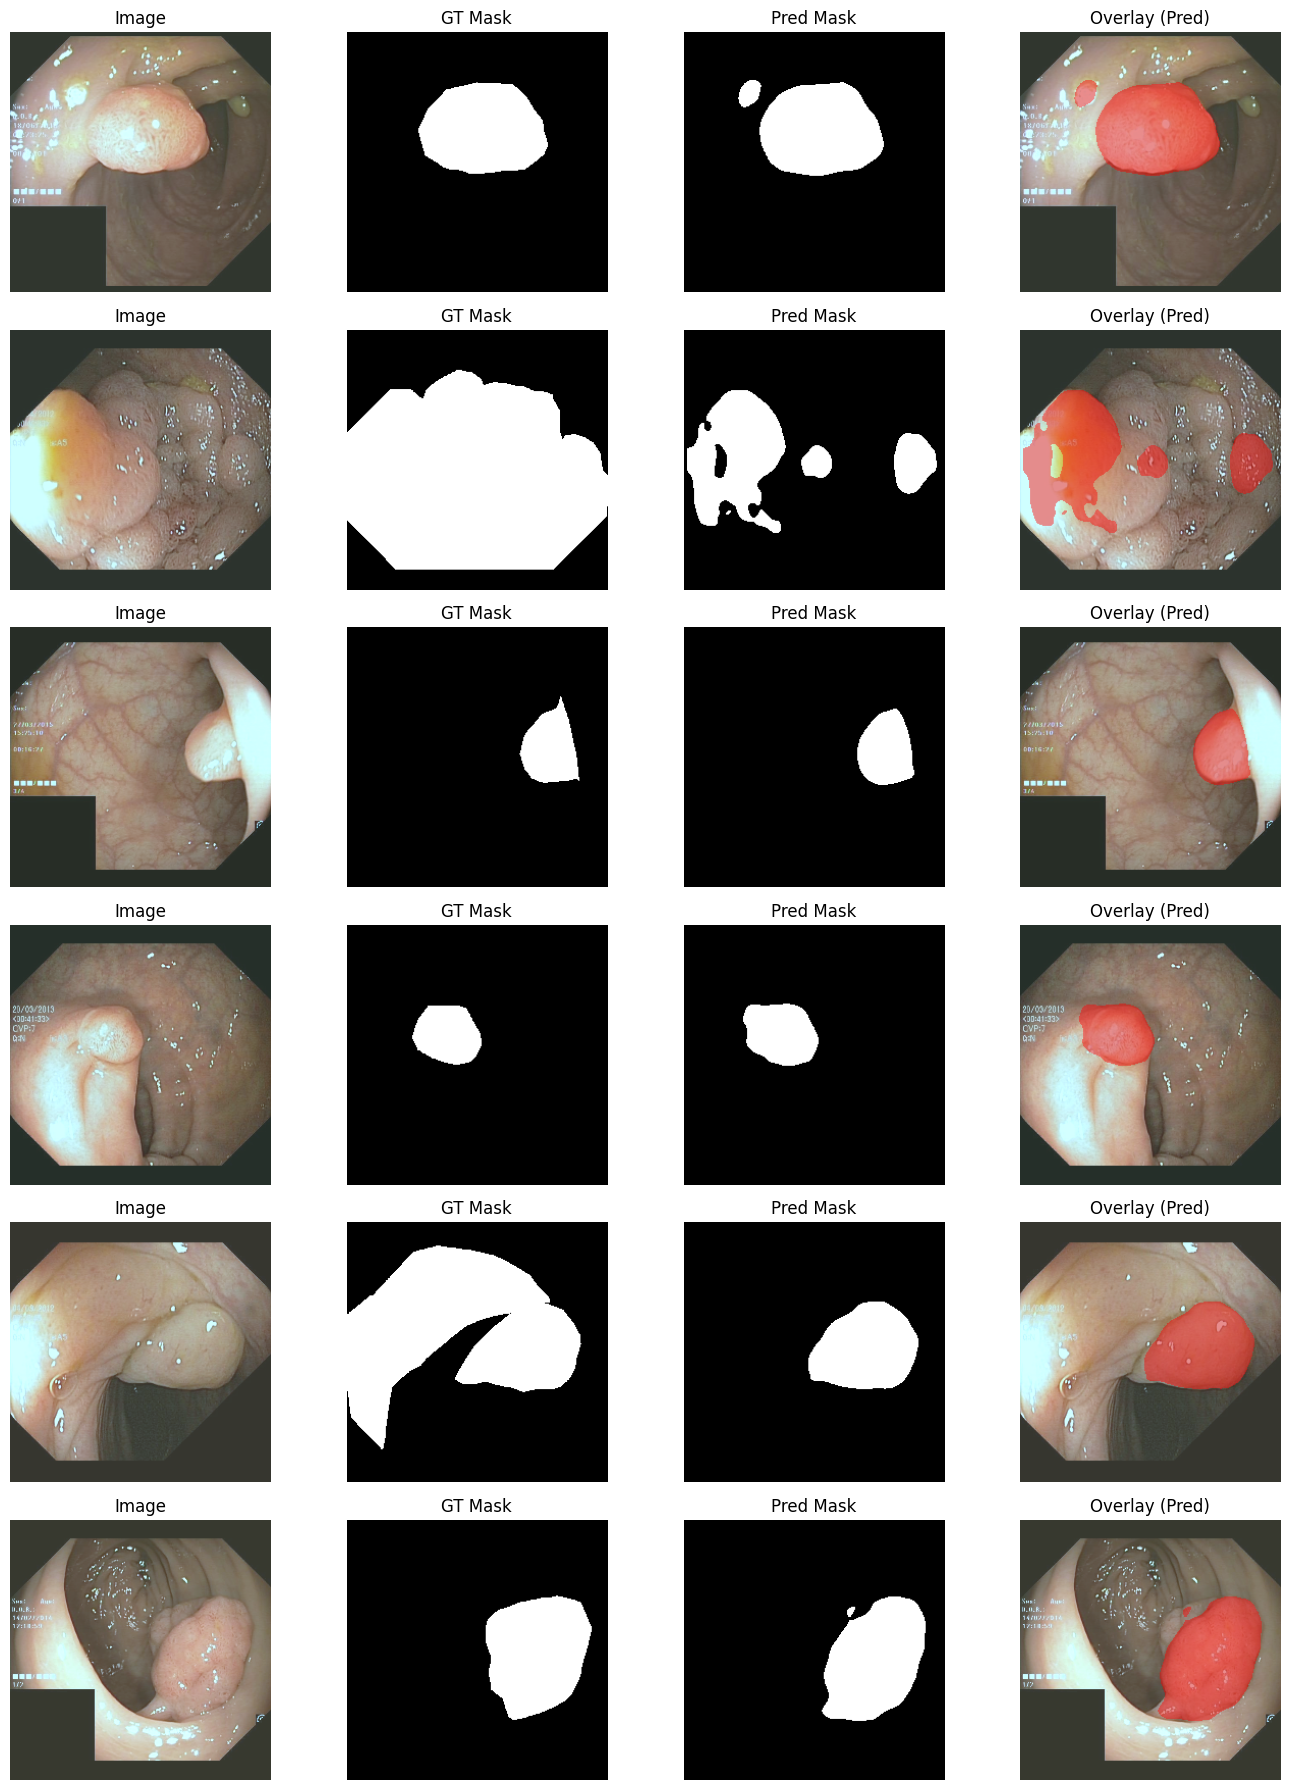

In [ ]:
import torch, numpy as np
import matplotlib.pyplot as plt

# --- (reuse your existing helpers; included here for completeness) ---
def denorm(img_tensor, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
    if img_tensor.ndim == 4:
        img_tensor = img_tensor[0]
    img = img_tensor.detach().cpu().float().clone()
    m = torch.as_tensor(mean)[:, None, None]
    s = torch.as_tensor(std)[:, None, None]
    img = img * s + m
    img = img.clamp(0, 1)
    return img.permute(1, 2, 0).numpy()

def to_mask(mask_tensor):
    if mask_tensor.ndim == 3:
        mask_tensor = mask_tensor[0]
    return mask_tensor.detach().cpu().float().numpy()

def overlay_mask(image_hwc, mask_hw, alpha=0.45, color=(1.0, 0.0, 0.0)):
    img = image_hwc.copy()
    mask3 = mask_hw[..., None]
    color_arr = np.array(color, dtype=np.float32).reshape(1,1,3)
    return (1 - alpha*mask3) * img + (alpha*mask3) * color_arr

@torch.no_grad()
def visualize_predictions_6(model, data_loader, device="cuda", threshold=0.5,
                            mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225),
                            save_path=None):
    """
    Displays exactly 6 visuals (rows): Image | GT Mask | Pred Mask | Overlay(Pred)
    """
    model.eval(); model.to(device)

    images_all, gts_all, preds_all, overlays_all = [], [], [], []
    collected = 0

    for images, masks in data_loader:
        images, masks = images.to(device), masks.to(device)
        probs = torch.sigmoid(model(images))
        preds = (probs > threshold).float()

        for i in range(images.size(0)):
            img = denorm(images[i], mean, std)
            gt  = to_mask(masks[i])
            pr  = to_mask(preds[i])
            ov  = overlay_mask(img, pr, alpha=0.45, color=(1.0, 0.0, 0.0))

            images_all.append(img); gts_all.append(gt); preds_all.append(pr); overlays_all.append(ov)
            collected += 1
            if collected == 6:
                break
        if collected == 6:
            break

    # handle case with <6 available
    n = min(6, collected)
    fig, axes = plt.subplots(n, 4, figsize=(14, 3*n))
    if n == 1:  # keep indexing consistent for single row
        axes = np.array([axes])

    for r in range(n):
        axes[r, 0].imshow(images_all[r]);       axes[r, 0].set_title("Image");           axes[r, 0].axis("off")
        axes[r, 1].imshow(gts_all[r], cmap="gray");  axes[r, 1].set_title("GT Mask");         axes[r, 1].axis("off")
        axes[r, 2].imshow(preds_all[r], cmap="gray");axes[r, 2].set_title("Pred Mask");       axes[r, 2].axis("off")
        axes[r, 3].imshow(overlays_all[r]);     axes[r, 3].set_title("Overlay (Pred)");  axes[r, 3].axis("off")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

# ===== Example call =====
visualize_predictions_6(model, test_loader, device=cfg.DEVICE, threshold=0.5, save_path=None)
